In [14]:
%pip install matplotlib seaborn plotly streamlit
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
%pip install jaxtyping transformer_lens
%pip install -U -q git+https://github.com/Parry-Parry/MechIR.git

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached https://download.pytorch.org/whl/cpu/torch-2.6.0-cp311-none-macosx_11_0_arm64.whl.metadata (28 kB)
Using cached https://download.pytorch.org/whl/cpu/torch-2.6.0-cp311-none-macosx_11_0_arm64.whl (66.5 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.4.1
    Uninstalling torch-2.4.1:
      Successfully uninstalled torch-2.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformer-lens 2.14.0 requires torch<2.5,>=2.2, but you have torch 2.6.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
  Using cached torch-2.4.1-cp311-none-macosx_11_0_arm64.whl.metadata (26 kB)
Using cached torch-2.4.1-cp311-none-macosx_11_0_arm64.whl (62.1 MB)
  Attempting uninstall: to

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

In [16]:
DIR = r'../data/patching/'

In [17]:
out = {}
for file in os.listdir(DIR):
    out[file] = np.load(DIR + file)

In [18]:
def plot_components(
        data, # shape: (num_layers, num_heads) or (num_layers, num_heads + 1) if include_mlp=True
        save_path,
        title="",
        include_mlp=False
    ):
    # set talk context 
    sns.set_context("talk")

    data = data.astype(float)
    plt.figure(figsize=(10, 6))

    ax = sns.heatmap(
        data,
        cmap='RdBu',
        vmin=-1,
        vmax=1,
        xticklabels=True,
        yticklabels=True,
        fmt=".2f",
        #annot_kws={"size": 8},
        annot=False
    )

    #for i in range(data.shape[0]):
        #for j in range(data.shape[1]):
            #plt.text(j+0.5, i+0.5, f'{data[i, j]:.2f}', ha='center', va='center', color='black')

    
    if include_mlp:
        new_labels = list(map(str, range(data.shape[1]-1)))
        new_labels.append('MLP')
        ax.set_xticklabels(new_labels)

    plt.title(title)
    plt.xlabel('Head')
    plt.ylabel('Layer')

    if save_path:
        plt.savefig(save_path)
        plt.close()

    return plt.gcf()

In [19]:
def plot_multiple_components(
    data_list,  # list of arrays, each with shape (num_layers, num_heads) or (num_layers, num_heads + 1)
    titles,     # list of titles for each heatmap
    save_path=None,
    include_mlp=False
):
    # Set talk context
    sns.set_context("talk")
    
    # Create figure with GridSpec for better control over spacing
    fig = plt.figure(figsize=(5 * len(data_list), 6))
    gs = GridSpec(1, len(data_list) + 1, width_ratios=[10] * len(data_list) + [0.5])
    
    # Store the first norm for consistent color scaling
    vmin = min(data.min() for data in data_list)
    vmax = max(data.max() for data in data_list)
    
    axes = []
    for idx, (data, title) in enumerate(zip(data_list, titles)):
        data = data.astype(float)
        
        # Create subplot
        ax = fig.add_subplot(gs[0, idx])
        axes.append(ax)
        
        # Create heatmap
        hm = sns.heatmap(
            data,
            cmap='RdBu',
            vmin=-1,
            vmax=1,
            xticklabels=True,
            yticklabels=True,
            fmt=".2f",
            annot=False,
            cbar=False,  # Don't show colorbar for individual plots
            ax=ax
        )
        # rotate x ticks
        plt.xticks(rotation=0)
        plt.yticks(rotation=0)
        
        # Set labels and title
        if include_mlp:
            new_labels = list(map(str, range(data.shape[1]-1)))
            new_labels.append('MLP')
            ax.set_xticklabels(new_labels)
        
        ax.set_title(title)
        
        # Only show y-label for the leftmost plot
        if idx == 0:
            ax.set_ylabel('Layer')
        else:
            ax.set_ylabel('')
        
        ax.set_xlabel('Head')
    
    # Add a single colorbar on the right
    cbar_ax = fig.add_subplot(gs[0, -1])
    cbar = plt.colorbar(axes[0].collections[0], cax=cbar_ax)
    cbar.outline.set_visible(False)  
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    
    return fig

In [20]:
components = []
names = []
for file in out:
    if 'rel_3' in file:
        components.append(out[file])
        name = '' 
        if 'z' in file:
            name += 'Cross-Encoder'
        else:
            name += 'Bi-Encoder' 
        if 'TDC' in file:
            name += ' TDC'
        else:
            name += ' TFC1'
        names.append(name)


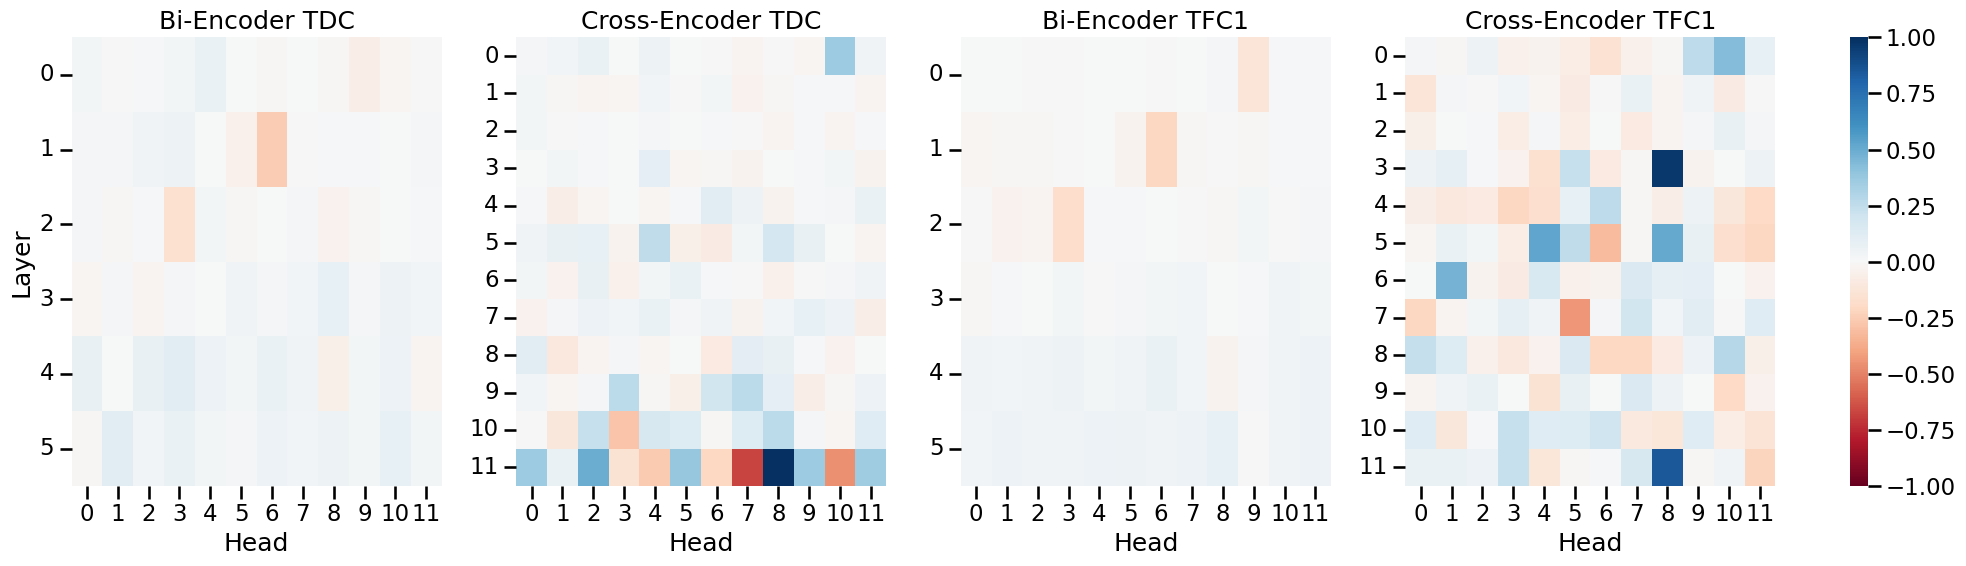

In [21]:
plot_multiple_components(components[::-1], names[::-1], save_path='plot/patch.pdf')